In [4]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

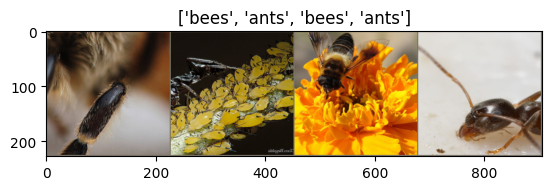

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\zhouq/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 53.4MB/s]


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5936 Acc: 0.6762
val Loss: 0.2940 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.5449 Acc: 0.7582
val Loss: 0.2841 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.5178 Acc: 0.7910
val Loss: 0.2884 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.6405 Acc: 0.7377
val Loss: 0.2712 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.6230 Acc: 0.7746
val Loss: 0.2461 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.4207 Acc: 0.8320
val Loss: 0.3696 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4861 Acc: 0.7746
val Loss: 0.3242 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.3135 Acc: 0.8975
val Loss: 0.2877 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3422 Acc: 0.8648
val Loss: 0.2684 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2657 Acc: 0.8811
val Loss: 0.2653 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3533 Acc: 0.8361
val Loss: 0.2368 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3320 Acc: 0.8361
val Loss: 0.2432 Acc: 0.9020

Ep

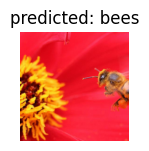

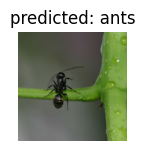

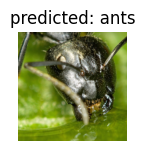

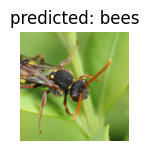

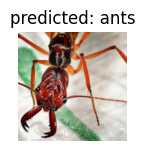

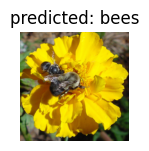

In [11]:
visualize_model(model_ft)

In [12]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6303 Acc: 0.6393
val Loss: 0.5054 Acc: 0.8039

Epoch 1/24
----------
train Loss: 0.5320 Acc: 0.7664
val Loss: 0.3230 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4498 Acc: 0.8361
val Loss: 0.3560 Acc: 0.8366

Epoch 3/24
----------
train Loss: 0.3579 Acc: 0.8361
val Loss: 0.2588 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.3689 Acc: 0.8279
val Loss: 0.3177 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.7211 Acc: 0.7131
val Loss: 0.2384 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4310 Acc: 0.8279
val Loss: 0.2119 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.4865 Acc: 0.7787
val Loss: 0.1909 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3950 Acc: 0.8074
val Loss: 0.1910 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3137 Acc: 0.8730
val Loss: 0.2025 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3839 Acc: 0.8361
val Loss: 0.1791 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2494 Acc: 0.8934
val Loss: 0.1951 Acc: 0.9346

Ep

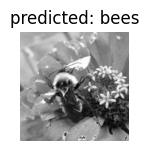

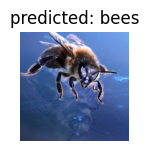

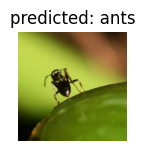

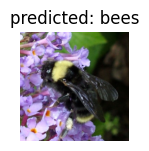

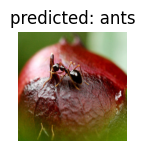

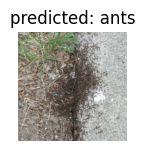

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [15]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

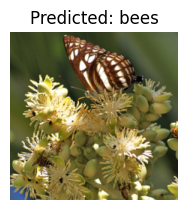

In [16]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()